# 1 Rossmann Store Sales
 <a href="https://www.kaggle.com/c/rossmann-store-sales" target="_blank">Source: Kaggle</a>

## 1.1 Business Problem

### 1.1.1 Scenario

Rossmann operates over 3,000 drug stores in 7 European countries. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality.

### 1.1.2 Task

Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance.

# 2 Data Extraction

## 2.1 Enviroment

### 2.1.1 Installations

In [1]:
#pip install pandas

In [2]:
#pip install inflection

In [3]:
#pip install seaborn

In [49]:
#pip install plotly

  Using cached plotly-5.1.0-py2.py3-none-any.whl (20.6 MB)
  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)
Note: you may need to restart the kernel to use updated packages.


### 2.1.2 Imports

In [50]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import Image
from datetime import datetime
from datetime import timedelta
import plotly.express as px

### 2.1.3 Settings

In [14]:
# Suprimir notação científica no Pandas
pd.set_option('display.float_format', lambda x: '%.2f' % x)
matplotlib.rcParams['figure.figsize'] = (14, 8)
sns.set_style("darkgrid")

## 2.2 Data Load

In [6]:
df_sales_raw = pd.read_csv('../dados/rossmann-store-sales/train.csv')
df_store_raw = pd.read_csv('../dados/rossmann-store-sales/store.csv')

/home/mg/Documents/data_science_em_producao/dsproducao/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
#df_sales_raw.head(3)

In [8]:
#df_store_raw.head(3)

In [9]:
df_raw = pd.merge(df_sales_raw, df_store_raw, how='inner', on='Store')

In [91]:
#df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
725282,796,4,2013-09-19,5447,646,1,0,0,0,a,c,7180.00,11.00,2012.00,0,NaN,NaN,NaN


## 2.3 Process File

In [46]:
#df_raw.to_csv('../dados/procedimentos/df_raw.csv', index=False)

# 3 Transformations

In [48]:
df1 = pd.read_csv('../dados/procedimentos/df_raw.csv')

## 3.1 Rename Columns

In [49]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 
                     'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 
                     'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 
                     'Promo2SinceYear', 'PromoInterval']
# Renomeando as colunas para o padrão snacke case
snackecase = lambda x: inflection.underscore(x)
cols_new = list(map(snackecase, cols_old))
df1.columns = cols_new

## 3.2 Dimensions

In [13]:
#print(f'Number of rows: {df1.shape[0]}')
#print(f'Number of columns: {df1.shape[1]}')

## 3.3 Types

In [50]:
df1['date'] = pd.to_datetime(df1['date'])
#df1.dtypes

## 3.4 Missing

In [15]:
#df1.isna().sum()

## 3.5 Fill NaN

### competition_distance              

Representa a distância do concorrente mais próximo

Suposição: 
1. Não possuem concorrentes próximos; 
2. A distância com relação ao concorrente é muito longa.

Tratamento: 
1. Preencher as linhas com um registro maior do que a distância máxima registrada na coluna.

In [51]:
#print(f"Maior distância do concorrente para a loja: {df1['competition_distance'].max()}")
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
#print(f"Dados NaN restantes: {df1['competition_distance'].isna().sum()}")                 

### competition_open_since_month

Representa aproximadamente o mês que o concorrente mais próximo abriu a loja

Suposição: 
1. Falta do concorrente próximo;
2. O concorrente próximo abriu a loja antes;
3. A data de abertura do concorrente não foi registrada. 

Tratamento:
1. Extrair da coluna date o mês da data da venda, por considerar que as vendas são influenciadas pela data no qual o concorrente próximo abriu. 

In [52]:
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

In [18]:
#print(f'Dados faltantes na coluna: {df1["competition_open_since_month"].isna().sum()}')

### competition_open_since_year

Representa aproximadamente o ano que o concorrente mais próximo abriu a loja

Suposição: 
1. Falta do concorrente próximo;
2. O concorrente próximo abriu a loja antes;
3. A data de abertura do concorrente não foi registrada. 

Tratamento:
1. Extrair da coluna date o ano da data da venda, por considerar que as vendas são influenciadas pela data no qual o concorrente próximo abriu. 

In [53]:
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

In [20]:
#print(f'Dados faltantes na coluna: {df1["competition_open_since_year"].isna().sum()}')

### promo2_since_week

In [54]:
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

In [22]:
#print(f'Dados faltantes na coluna: {df1["promo2_since_week"].isna().sum()}')

### promo2_since_year 

In [55]:
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

In [24]:
#print(f'Dados faltantes na coluna: {df1["promo2_since_year"].isna().sum()}')

### promo_interval

In [56]:
month_map = {1: 'Jan',
            2: 'Feb',
            3: 'Mar',
            4: 'Apr',
            5: 'May',
            6: 'Jun',
            7: 'Jul',
            8: 'Aug',
            9: 'Sep',
            10: 'Oct',
            11: 'Nov',
            12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [26]:
#print(f'Dados faltantes na coluna: {df1["promo_interval"].isna().sum()}')

## 3.6 Change Data Types

In [57]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
#df1.dtypes

## 3.7 Descriptive Statistical

In [58]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 3.7.1 Numerical Attribues

In [29]:
# Central Tendency - mean and median
ct1 = pd.DataFrame(num_attributes.apply(np.mean))
ct2 = pd.DataFrame(num_attributes.apply(np.median))

# Dispersion - std, min, max, range, skew, kurtosis 
d1 = pd.DataFrame((num_attributes).apply(np.std))
d2 = pd.DataFrame(num_attributes).apply(min)
d3 = pd.DataFrame(num_attributes).apply(max)
d4 = pd.DataFrame(num_attributes).apply(lambda x: x.max() - x.min())
d5 = pd.DataFrame(num_attributes).apply(lambda x: x.skew())
d6 = pd.DataFrame(num_attributes).apply(lambda x: x.kurtosis())

# Concatenate

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6], axis=1).reset_index()
m.columns = ['features', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
#m

### 3.7.2 Categorical Attributes

In [30]:
#cat_attributes.apply(lambda x: x.unique().shape)

In [31]:
'''
ax1 = df1[df1['sales'] > 0]
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=ax1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=ax1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=ax1)
'''

"\nax1 = df1[df1['sales'] > 0]\nplt.subplot(1, 3, 1)\nsns.boxplot(x='state_holiday', y='sales', data=ax1)\n\nplt.subplot(1, 3, 2)\nsns.boxplot(x='store_type', y='sales', data=ax1)\n\nplt.subplot(1, 3, 3)\nsns.boxplot(x='assortment', y='sales', data=ax1)\n"

## 3.8 Feature Engineering

### 3.8.1 Mind Map Hypothesis

Mind Map Hypothesis

Phenomenon
- Sales forecast

Agents:
- Customers, stores, time and products

Agents attributes
- Image below

Hypothesis:
- Topics below

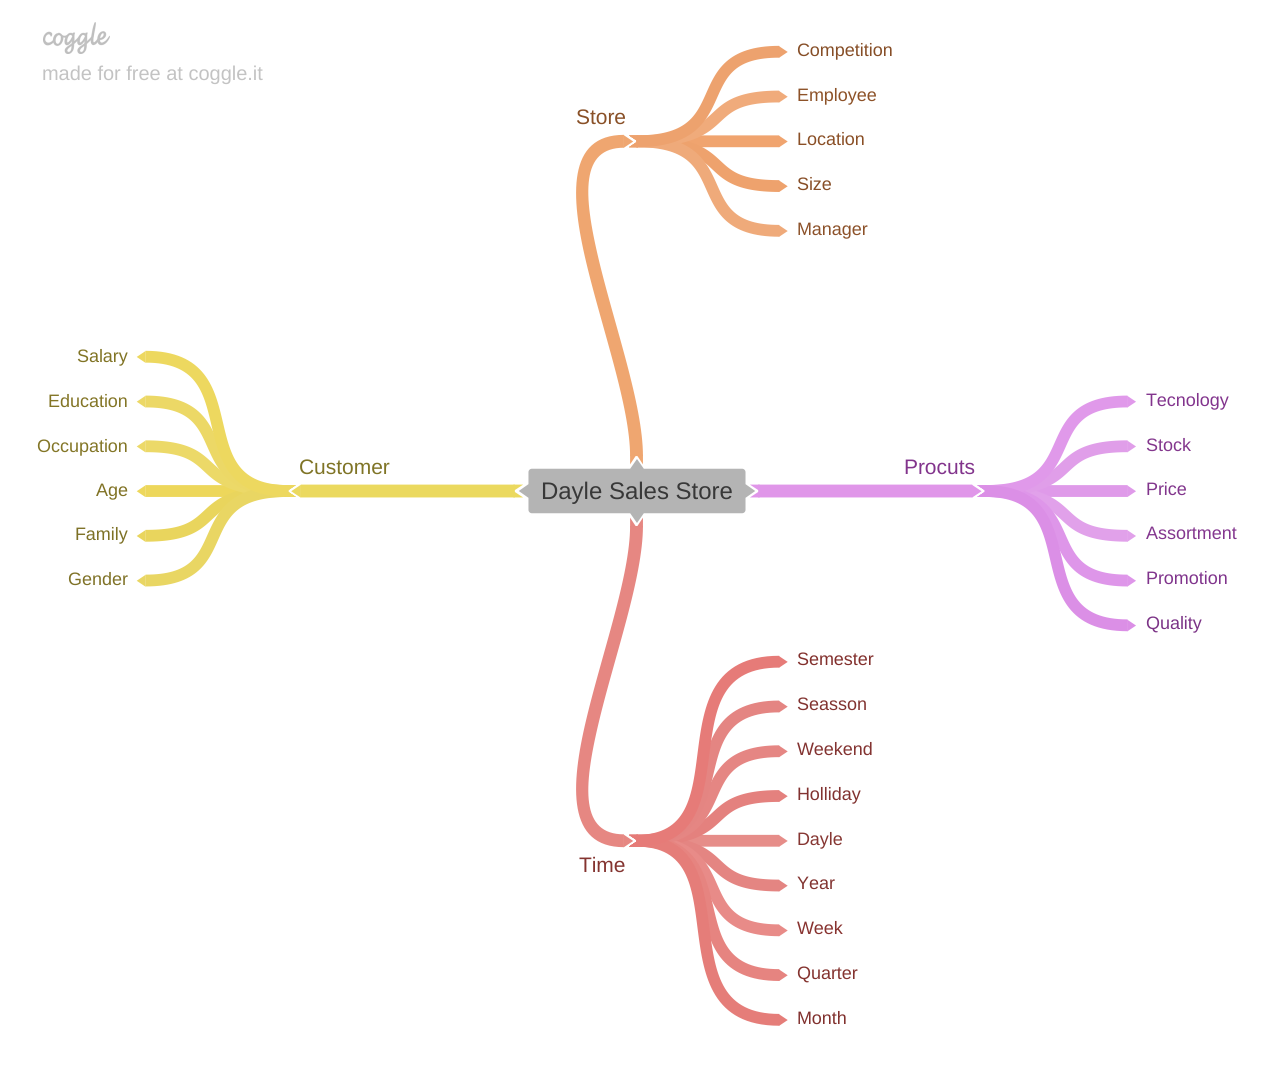

In [33]:
Image('../img/Dayle_Sales_Store.png')

#### 3.8.1.1 Store Hyphotesis

1. Lojas maiores deveriam vender mais;

2. Lojas com mais funcionários deveriam vender mais;

3. Lojas com concorrentes por perto deveriam vender menos;

4. Lojas com maior estoque deveriam vender mais;

5. Lojas com mais produtos na vitrine deveriam vender mais;

6. Lojas com maior sortimento deveriam vender mais; 

7. Lojas com concorrentes a mais tempo deveriam vender mais;

8. Lojas com promoção ativas deveriam vender mais;

9. Lojas com promoção ativas por mais tempo deveriam vender mais;

10. Lojas com promoção consecutivas deveriam vender mais; 

#### 3.8.1.2 Product Hyphotesis

1. Produtos mais baratos deveriam vender mais;

2. Produtos em promoção deveriam vender mais;

3. Produtos mais caros deveriam vender menos;

4. Produtos com maior qualidade deveriam vender mais;

#### 3.8.1.3 Time Hyphotesis

1. No segundo semestre deveriam aumentar as vendas;

2. No verão as vendas deveriam ser maiores;

3. No final de semana as vendas são menores;

4. Durante as férias escolares as vendas são menores;

5. No natal as vendas são maiores; 

6. As vendas são maiores com o passar dos anos;

### 3.8.2 Hyphotesis List

1. Lojas com maior sortimento deveriam vender mais; 

2. Lojas com concorrentes por perto deveriam vender menos;

3. Lojas com concorrentes a mais tempo deveriam vender mais;

4. Lojas com promoção ativas deveriam vender mais;

5. Lojas com promoção ativas por mais tempo deveriam vender mais;

6. Lojas com promoção consecutivas deveriam vender mais; 

7. No natal as vendas são maiores; 

8. As vendas são maiores com o passar dos anos;

9. No segundo semestre deveriam aumentar as vendas;

10. No final de semana as vendas são menores;

11. Durante as férias escolares as vendas são menores;

12. Depois do dia 10 de cada mais as vendas deveriam ser maiores;

### 3.8.3 Feature Engineering

In [59]:
# year
df1['year'] = df1['date'].dt.year

# month
df1['month'] = df1['date'].dt.month

# day
df1['day'] = df1['date'].dt.day

# week of year
df1['week_of_year'] = df1['date'].dt.isocalendar().week

# year week
df1['year_week'] = df1['date'].dt.strftime('%Y-%W')

# competition since
df1['competition_since'] = df1.apply(lambda x: datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df1['competition_time_month'] = ((df1['date'] - df1['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo since
df1['promo_since'] = df1['promo2_since_year'].astype(str) + '-' + df1['promo2_since_week'].astype(str)
df1['promo_since'] = df1['promo_since'].apply(lambda x: datetime.strptime(x + '-1', '%Y-%W-%w') - timedelta(days=7))
df1['promo_time_week'] = ((df1['date'] - df1['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# Assortment
df1['assortment'] = df1['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b'else 'extended')

# state holiday
df1['state_holiday'] = df1['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

## 3.9 Data Filter

### 3.9.1 Row Filter

In [60]:
df1 = df1[(df1['open'] != 0) & (df1['sales'] > 0)]

### 3.9.2 Columns Filter

In [61]:
df1.drop(['customers', 'open', 'promo_interval', 'month_map'], axis=1, inplace=True)

## 3.10 Process File

In [62]:
#df1.to_csv('../dados/procedimentos/df1.csv', index=False)

# 4 Exploratory Data Analysis

In [3]:
df2 = pd.read_csv('../dados/procedimentos/df1.csv')

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

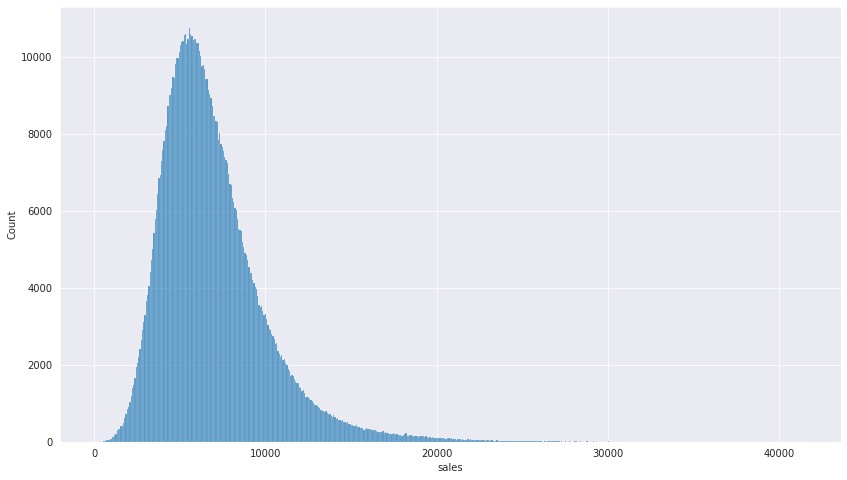

In [121]:
sns.histplot(df2['sales']);

### 4.1.2 Numerical Variable

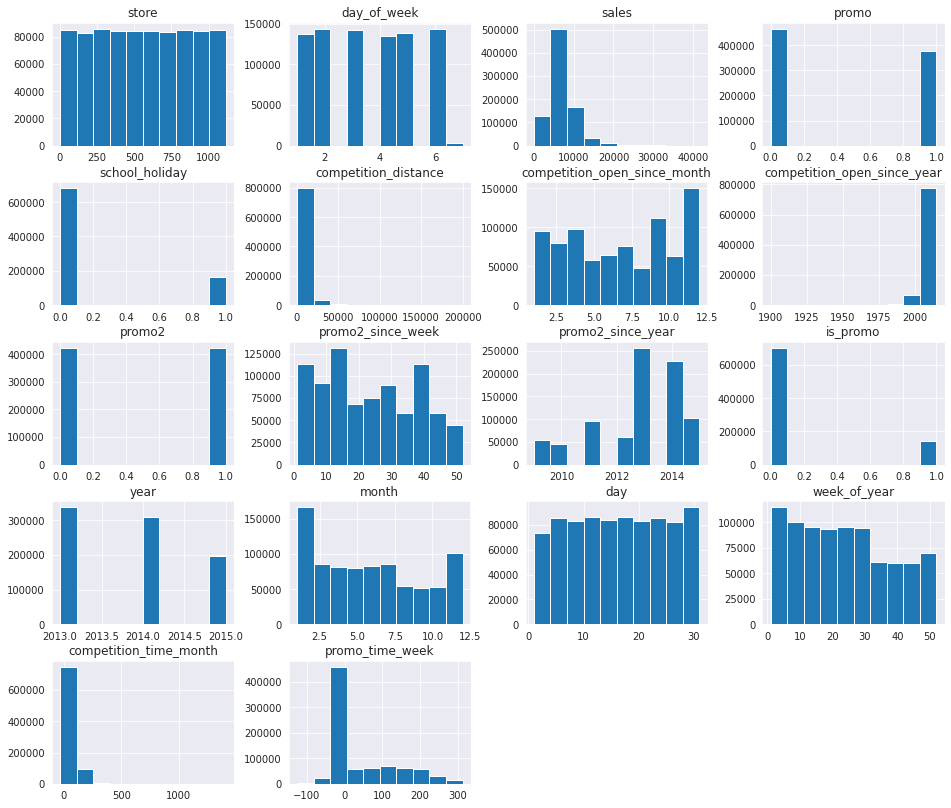

In [86]:
df2.select_dtypes(include=['int64', 'float64']).hist(figsize=(16, 14));

store: Number of sales by store is closely distribuited

day_of_week: Is balanced in all days

sales: Distribuition is left asymmetric

promo: Have more no promo events

promo2: Have much more no promo2 events

competition_distance: Usually short distances

### 4.1.3 Categorical Variable

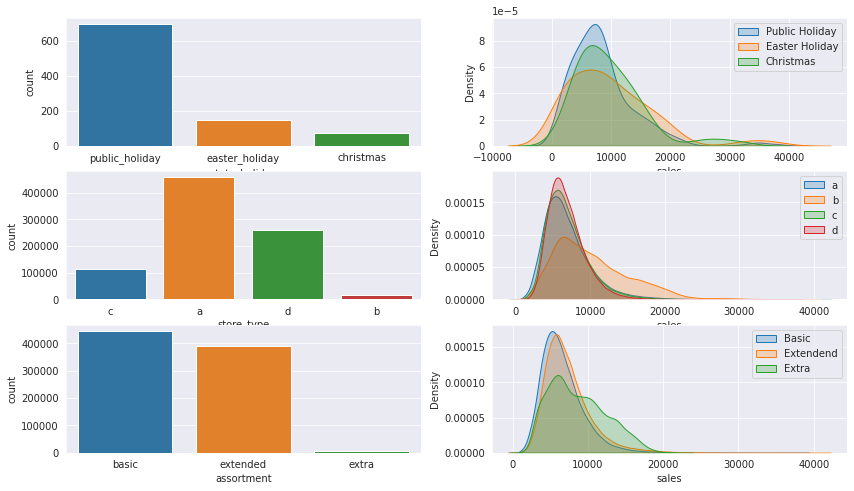

In [120]:
# state_holiday
plt.subplot(3, 2, 1)
sns.countplot(x='state_holiday', data=df2[df2 != 'regular_day'])

plt.subplot(3, 2, 2)
sns.kdeplot(data=df2[df2['state_holiday'] == 'public_holiday']['sales'], shade=True, label='Public Holiday')
sns.kdeplot(data=df2[df2['state_holiday'] == 'easter_holiday']['sales'], shade=True, label='Easter Holiday')
sns.kdeplot(data=df2[df2['state_holiday'] == 'christmas']['sales'], shade=True, label='Christmas')
plt.legend()

# store_type
plt.subplot(3, 2, 3)
sns.countplot(x='store_type', data=df2)

plt.subplot(3, 2, 4)
sns.kdeplot(data=df2[df2['store_type'] == 'a']['sales'], shade=True, label='a')
sns.kdeplot(data=df2[df2['store_type'] == 'b']['sales'], shade=True, label='b')
sns.kdeplot(data=df2[df2['store_type'] == 'c']['sales'], shade=True, label='c')
sns.kdeplot(data=df2[df2['store_type'] == 'd']['sales'], shade=True, label='d')
plt.legend()

#assortment
plt.subplot(3, 2, 5)
sns.countplot(x='assortment', data=df2)

plt.subplot(3, 2, 6)
sns.kdeplot(data=df2[df2['assortment'] == 'basic']['sales'], shade=True, label='Basic')
sns.kdeplot(data=df2[df2['assortment'] == 'extended']['sales'], shade=True, label='Extendend')
sns.kdeplot(data=df2[df2['assortment'] == 'extra']['sales'], shade=True, label='Extra')
plt.legend();

## 4.2 Bivariate Analysis

### 4.2.1 Stores with more assortment should sell more
False

Basic assortment have more sales

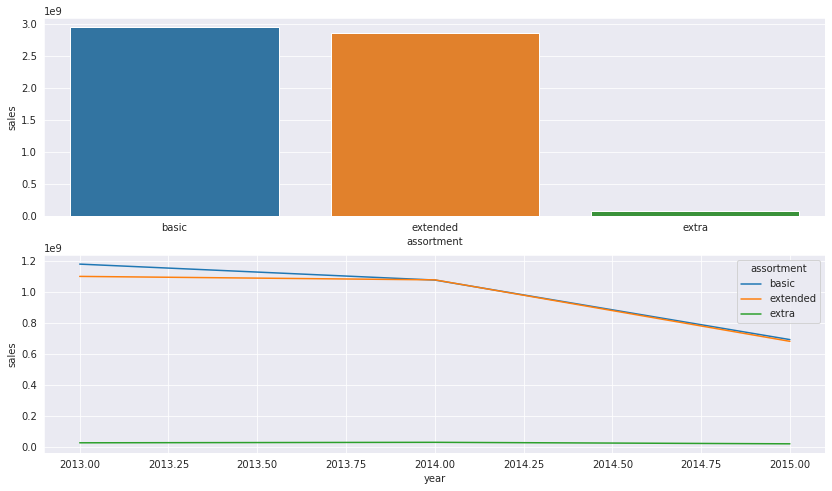

In [56]:
plt.subplot(2, 1, 1)
aux1 = df2[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)

plt.subplot(2, 1, 2)
aux2 = df2[['assortment', 'year', 'sales']].groupby(['assortment', 'year']).sum().reset_index()
sns.lineplot(x='year', y='sales', hue='assortment', data=aux2);

In [58]:
aux3 = df2[df2['assortment'] == 'extra'][['year_week', 'sales']].groupby('year_week').sum().reset_index()
px.line(x=aux3['year_week'], y=aux3['sales'], title='Assortment Extra')

### 4.2.2 Lojas com concorrentes por perto deveriam vender menos;

### 4.2.3 Lojas com concorrentes a mais tempo deveriam vender mais;

## 4.3 Multivariate Analysis

# 5 Data Modeling

# 6 Machine Learning

# 7 Business Metrics

# 8 Deploy 